# Overview of Content:

### mlo_09_synth_trend_prediction:

__Sections__:
- Main Module Import Section and Notebook Settings
- Initialize Custom Functions
- Read Notebook Variables
- Main Peaks of Filtered FFT Results in Time Period-Range of 2 - 6 Years: Mauna Loa and ONI
- Calculate Reconstructed Development of Atmospheric CO2-Concentrations
- Reconstructed Development of CO2-Concentrations without long-term Trend
- Reconstructed Development of CO2-Concentrations with long-term Trend


__Save Dataframes as Notebook Variables and as Text Files__:
- Create Dataframe with Reconstructed CO2-Trends:
    - synth
    - synth_future
    

__Plot and Save Figures__:
- Reconstructed Development of CO2-Concentrations without long-term Trend:
    - synth_mmlo_prog_detrended_noann
    - synth_mmlo_raw_detrended_noann_volc
    - synth_mmlo_prog_detrended_ann
- Reconstructed Development of CO2-Concentrations with long-term Trend:
    - synth_mmlo_prog
    - synth_mmlo_prog_volc
    - synth_mmlo_prog_detail
    - synth_mmlo_prog_noann
    - synth_mmlo_prog_noann_1980_2013_volc

## Main Module Import Section and Notebook Settings

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import date
from datetime import timedelta
import time
from scipy.fftpack import fft
from scipy import signal
import math
import matplotlib.pyplot as plt
%matplotlib notebook

plt.style.use('ggplot')
from matplotlib import rcParams
rcParams['lines.linewidth'] = 0.9
rcParams['figure.figsize'] = 9, 4.5
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%config InlineBackend.figure_format = 'retina'
import matplotlib

myred = '#E24A33'
myblue = '#348ABD'

## Initialize Custom Functions

In [2]:
def yr_fraction(t_date):
    """
    returns a datetime as decimal years
    """
    
    if np.size(t_date) == 1:
        t_dates = []
        t_dates.append(t_date)
    else:
        t_dates = t_date
        
    date_list = []
    for i in t_dates:
        # based on a script from ninjagecko
        # from: https://stackoverflow.com/questions/6451655/python-how-to-convert-datetime-dates-to-decimal-years
        def sinceEpoch(i): # returns seconds since epoch
            return time.mktime(i.timetuple())

        s = sinceEpoch

        year = i.year
        startOfThisYear = datetime(year=year, month=1, day=1)
        startOfNextYear = datetime(year=year+1, month=1, day=1)

        yearElapsed = s(i) - s(startOfThisYear)
        yearDuration = s(startOfNextYear) - s(startOfThisYear)
        fraction = yearElapsed/yearDuration
        date_list.append(i.year + fraction)
    
    return date_list

In [3]:
def yr_sec(a=1):
    """
    convert years into seconds
    """
    return a * 60 * 60 * 24 * 365

In [4]:
def m_sec(m=1):
    """
    convert months into seconds
    """
    m_per_yr = 12 / m
    return yr_sec() / m_per_yr

In [5]:
def get_fs(t):
    """
    returns sampling rate in Hz from time period in s
    """
    return 1 / t

In [6]:
def get_res(bins, fs=get_fs(m_sec())):
    """
    calculate the resolution / time per bin in s
    """
    return 0.5 * fs / bins

In [7]:
def bin_frq(bin_peak, bins_tot):
    return (bin_peak * get_res(bins_tot))

In [8]:
def bin_yr(bin_peak, bins_tot):
    """
    calculates the corresponding year of a bin
    """
    if bin_peak <=0:
        bin_peak = 0.5
        
    return (bin_peak * get_res(bins_tot) * yr_sec())**-1

In [9]:
def yr_bin(yr, ax_yr):
    """
    converts a year (period of frequency into the corresponding bin.
    axis array with years is needed.
    """
    bin_ax = np.where(ax_yr >= yr)
    closest_bin = np.max(bin_ax)
    return closest_bin

In [10]:
def norm_values(data):
    """
    returns normalized values
    """
    return data / np.max(np.abs(data))

## Read Notebook Variables

In [11]:
# read internal jupyter notebook variables

# stored via notebook: mlo_01_import.ipynb:
%store -r mmlo
%store -r oeni
%store -r eq_trend_mmlo
%store -r p_trend_mmlo

# stored via notebook: mlo_06-1_filter_mmlo.ipynb:
%store -r filtered_mmlo

# stored via notebook: mlo_06-2_filter_oeni.ipynb:
%store -r filtered_oeni

# # stored via notebook: mlo_07_filtered_correlations_fft.ipynb:
%store -r cut_a_filtered
%store -r fft_filtered_mmlo_cut_a
%store -r fft_filtered_oeni_cut_a

# stored via notebook: mlo_08_spectral_analysis.ipynb:
%store -r fft_peaks_merged
%store -r fft_peaks_merged_all
%store -r fft_peaks_years
%store -r fft_peaks_years_short

## Main Peaks of Filtered FFT Results in Time Period-Range of 2 - 6 Years: Mauna Loa and ONI

In [12]:
x_start = 6.2
x_stop = 1.8
x_years = [6, 5.5, 5, 4.5, 4, 3.5, 3, 2.5, 2]

fig,ax = plt.subplots()
ax.plot(fft_filtered_mmlo_cut_a.period_yr.values, fft_filtered_mmlo_cut_a.mag_norm.values, color=myred, label='Mauna Loa Gefiltert')
ax.plot(fft_filtered_oeni_cut_a.period_yr.values, fft_filtered_oeni_cut_a.mag_norm.values, color=myblue, label='ONI Gefiltert')

ax.set_ylabel('Normalisierte Magnitude')
ax.set_xlabel('Periode der Frequenz [Jahre]')
ax.set_xlim(x_start, x_stop)
ax.set_ylim(-0.05, 1.05)
# ax.set_xscale('log')
# ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xticks(x_years)
plt.vlines(fft_peaks_years_short.mean_filtered_cut_a.iloc[1], -0.1, 1.1, linestyles='dashed', colors='dimgrey')
plt.vlines(fft_peaks_years_short.mean_filtered_cut_a.iloc[2], -0.1, 1.1, linestyles='dashed', colors='dimgrey')
plt.vlines(fft_peaks_years_short.mean_filtered_cut_a.iloc[3], -0.1, 1.1, linestyles='dashed', colors='dimgrey')

plt.legend()
plt.savefig('plots/fft_mmlo_oeni_filtered_detail_means.pdf')

<IPython.core.display.Javascript object>

(6.2, 1.8)

(-0.05, 1.05)

## Calculate Reconstructed Development of Atmospheric CO2-Concentrations

### Create Time Axis for Measured Mauna Loa CO2-Trend

In [13]:
data = filtered_mmlo.mmlo_filtered  # time domain data with datetime in index
dt = data.index[-1] - data.index[0]  # calculate time span / delta time
dt = dt.total_seconds()  # convert timedelta into seconds
fs = get_fs(t=m_sec())  # calculate sampling rate for one data point per month
t = np.arange(0, dt, 1 / fs)  # create time axis in sec with sampling rate of one data point per month

### Create CO2-Trend with Forecast

##### Time Axis with Future Date for Forecast:

In [14]:
# create time axis with future date for forecast
future_yr = pd.datetime(2025, 7, 31)  # future date
dt_future = future_yr - data.index[0]
dt_future = dt_future.total_seconds()
t_future = np.arange(0, dt_future, 1/fs)  # time axis with future date in seconds
future_a = yr_fraction(data.index[0])  # first datetime in seconds
future_b = yr_fraction(future_yr)  # last datetime in seconds
t_future_dec = np.linspace(future_a, future_b, num=t_future.size, endpoint=True) # time axis as decimal date

##### CO2-Trend from Fit Function (without Annual Variation):

*with terms from fit function (see mlo_01_import.ipynb) with the following equation:*

In [15]:
eq_trend_mmlo  # equation

'0.013 x^2 + -48.541 x + 47071.325'

In [16]:
# calculate co2-trend (without annual variation) from above function / equation
future_trend =  (p_trend_mmlo[0] * t_future_dec**2) + (p_trend_mmlo[1] * t_future_dec) + p_trend_mmlo[2]
future_index = pd.date_range(data.index[0], future_yr, freq='M')  # indexed by monthly datetime
synth_future = pd.DataFrame(index=future_index)
synth_future['trend'] = future_trend  # dataframe with co2-trend including forecast

### Create Table with Filtered Mauna Loa FFT Peak Properties

In [17]:
peaks = fft_peaks_merged_all.loc[['mmlo_filtered_0-2_yr', 'mmlo_filtered_2-3_yr', \
                          'mmlo_filtered_3-4_yr', 'mmlo_filtered_4-6_yr']]
peaks.drop(['bin', 'bins_total', 'mag_norm', 'amp_norm', 'pha_norm', 'freq'], axis=1)

period_yr         mag       amp       pha
mmlo_filtered_0-2_yr   0.999439  549.977305  0.005150 -0.736158
mmlo_filtered_2-3_yr   2.521246   22.479313  0.000210 -0.288646
mmlo_filtered_3-4_yr   3.641571   49.205628  0.000461 -1.845475
mmlo_filtered_4-6_yr   5.051078   32.056362  0.000300 -1.281097

##### Get Single Peak Properties of Filtered Mauna Loa FFT Results for a certain Range of Time-Periods:

In [18]:
peak_f1 = fft_peaks_merged_all.loc['mmlo_filtered_0-2_yr']  # 0 - 2 years
peak_f2 = fft_peaks_merged_all.loc['mmlo_filtered_2-3_yr']  # 2 - 3 years
peak_f3 = fft_peaks_merged_all.loc['mmlo_filtered_3-4_yr']  # 3 - 4 years
peak_f4 = fft_peaks_merged_all.loc['mmlo_filtered_4-6_yr']  # 4 - 6 years
peak_f5 = fft_peaks_merged_all.loc['mmlo_filtered_6-10_yr']  # 6 - 10 years

### Create Dataframe with Reconstructed CO2-Trends:

##### Gain Settings for Creating Synthetic Frequency Signals

In [19]:
# gain factor to increase amplitudes (compensate for lost fft spectral energy)
gain_fac = 950

# amplitude factor to balance out specific peaks
# 1: increased with l00% of gain factor -> normal setting
# 0: 0% of gain factor and amplitude - resulting in eleminating complete frequency signal
fac_f1 = 0.63  # 0 - 2 year peak: balancing out the dominant 1-year peak
fac_f2 = 1  # 2 - 3 year peak
fac_f3 = 1  # 3 - 4 year peak
fac_f4 = 1  # 4 - 5 year peak
fac_f5 = 0  # 6 - 10 year peak: eliminate uncertain peak due to Camparison of Mauna Loa- and ONI-FFT Results

In [20]:
# initialize dataframe with detrended Mauna Loa Data
synth = pd.DataFrame(index=filtered_mmlo.index)
synth['detrended_filtered'] = filtered_mmlo.mmlo_filtered.values  # no annual variations
synth['detrended_unfiltered'] = filtered_mmlo.mmlo_unfiltered.values  # with annual variations (unfiltered)

# create synthetic frequency signals based on calculated fft peak properties
synth['f1'] = fac_f1 * gain_fac * peak_f1.amp * np.cos(2 * math.pi * peak_f1.freq * t + peak_f1.pha)  # 0 - 2 year peak
synth['f2'] = fac_f2 * gain_fac * peak_f2.amp * np.cos(2 * math.pi * peak_f2.freq * t + peak_f2.pha)  # 2 - 3 year peak
synth['f3'] = fac_f3 * gain_fac * peak_f3.amp * np.cos(2 * math.pi * peak_f3.freq * t + peak_f3.pha)  # 3 - 4 year peak
synth['f4'] = fac_f4 * gain_fac * peak_f4.amp * np.cos(2 * math.pi * peak_f4.freq * t + peak_f4.pha)  # 4 - 5 year peak
synth['f5'] = fac_f5 * gain_fac * peak_f5.amp * np.cos(2 * math.pi * peak_f5.freq * t + peak_f5.pha)  # 6 - 10 year peak

# create synthetic time series with calculated frequency signals (no long-term trend):
synth['raw_noann'] = synth.f2 + synth.f3 + synth.f4 + synth.f5  # without annual variation
synth['raw_ann'] = synth.f1 + synth.raw_noann  # with annual variation

%store synth
%store synth >data_results/synth.txt

synth.head()
synth.tail()

Stored 'synth' (DataFrame)
Writing 'synth' (DataFrame) to file 'data_results/synth.txt'.


detrended_filtered  detrended_unfiltered        f1        f2  \
1958-03-31           -0.067270              1.271950  2.283953  0.191684   
1958-04-30           -0.335590              2.947169  3.013109  0.199304   
1958-05-31           -0.578120              2.930049  2.932874  0.198346   
1958-06-30           -0.776778              2.464921  2.064802  0.188852   
1958-07-31           -0.918640              1.157444  0.642077  0.171231   

                  f3        f4   f5  raw_noann   raw_ann  
1958-03-31 -0.118718  0.081456 -0.0   0.154422  2.438376  
1958-04-30 -0.057083  0.109314 -0.0   0.251536  3.264645  
1958-05-31  0.005732  0.135998 -0.0   0.340076  3.272951  
1958-06-30  0.068429  0.161219 -0.0   0.418500  2.483302  
1958-07-31  0.129711  0.184706 -0.0   0.485649  1.127726

detrended_filtered  detrended_unfiltered        f1        f2  \
2017-02-28           -1.759344              1.890463  2.183138 -0.106131   
2017-03-31           -1.450168              2.457734  2.978942 -0.138813   
2017-04-30           -1.022513              4.090799  2.974534 -0.165522   
2017-05-31           -0.510416              4.547453  2.171097 -0.185107   
2017-06-30            0.043404              3.550172  0.784454 -0.196726   

                  f3        f4   f5  raw_noann   raw_ann  
2017-02-28  0.349038 -0.279659 -0.0  -0.036752  2.146386  
2017-03-31  0.383300 -0.283920 -0.0  -0.039434  2.939508  
2017-04-30  0.409640 -0.285128 -0.0  -0.041011  2.933523  
2017-05-31  0.427513 -0.283271 -0.0  -0.040866  2.130232  
2017-06-30  0.436551 -0.278369 -0.0  -0.038544  0.745910

### Create Dataframe with Reconstructed CO2-Trends including Forecast:

In [21]:
# create synthetic frequency signals based on calculated fft peak properties
synth_future['f1'] = fac_f1 * gain_fac * peak_f1.amp * np.cos(2 * math.pi * peak_f1.freq * t_future + peak_f1.pha)  # 0 - 2 year peak
synth_future['f2'] = fac_f2 * gain_fac * peak_f2.amp * np.cos(2 * math.pi * peak_f2.freq * t_future + peak_f2.pha)  # 2 - 3 year peak
synth_future['f3'] = fac_f3 * gain_fac * peak_f3.amp * np.cos(2 * math.pi * peak_f3.freq * t_future + peak_f3.pha)  # 3 - 4 year peak
synth_future['f4'] = fac_f4 * gain_fac * peak_f4.amp * np.cos(2 * math.pi * peak_f4.freq * t_future + peak_f4.pha)  # 4 - 5 year peak
synth_future['f5'] = fac_f5 * gain_fac * peak_f5.amp * np.cos(2 * math.pi * peak_f5.freq * t_future + peak_f5.pha)  # 6 - 10 year peak

# create synthetic time series including forecast without annual variations
synth_future['raw_noann'] = synth_future.f2 + synth_future.f3 + synth_future.f4 + synth_future.f5  # no long-term trend 
synth_future['prog_noann'] = synth_future.raw_noann + synth_future.trend  # with long-term trend

# create synthetic time series including forecast with annual variations
synth_future['raw_ann'] = synth_future.f1 + synth_future.raw_noann  # no long-term trend 
synth_future['prog_ann'] = synth_future.raw_ann + synth_future.trend  # with long-term trend

%store synth_future
%store synth_future >data_results/synth_future.txt

synth_future.head()
synth_future.tail()

Stored 'synth_future' (DataFrame)
Writing 'synth_future' (DataFrame) to file 'data_results/synth_future.txt'.


trend        f1        f2        f3        f4   f5  \
1958-03-31  314.438050  2.283953  0.191684 -0.118718  0.081456 -0.0   
1958-04-30  314.503733  3.013109  0.199304 -0.057083  0.109314 -0.0   
1958-05-31  314.569591  2.932874  0.198346  0.005732  0.135998 -0.0   
1958-06-30  314.635624  2.064802  0.188852  0.068429  0.161219 -0.0   
1958-07-31  314.701832  0.642077  0.171231  0.129711  0.184706 -0.0   

            raw_noann  prog_noann   raw_ann    prog_ann  
1958-03-31   0.154422  314.592472  2.438376  316.876425  
1958-04-30   0.251536  314.755269  3.264645  317.768378  
1958-05-31   0.340076  314.909667  3.272951  317.842542  
1958-06-30   0.418500  315.054124  2.483302  317.118927  
1958-07-31   0.485649  315.187481  1.127726  315.829558

trend        f1        f2        f3        f4   f5  \
2025-03-31  423.717378  3.023786 -0.191133  0.322329  0.257851  0.0   
2025-04-30  423.923709  2.916191 -0.174900  0.276539  0.243859  0.0   
2025-05-31  424.130214  2.025240 -0.151140  0.225034  0.227245  0.0   
2025-06-30  424.336895  0.590263 -0.120875  0.168878  0.208188  0.0   
2025-07-31  424.543751 -1.003272 -0.085409  0.109231  0.186892 -0.0   

            raw_noann  prog_noann   raw_ann    prog_ann  
2025-03-31   0.389047  424.106425  3.412833  427.130211  
2025-04-30   0.345498  424.269207  3.261690  427.185398  
2025-05-31   0.301139  424.431354  2.326379  426.456594  
2025-06-30   0.256190  424.593085  0.846453  425.183348  
2025-07-31   0.210715  424.754465 -0.792558  423.751193

## Reconstructed Development of CO2-Concentrations without long-term Trend

##### Reconstructed CO2-Development with Forecast (without Annual Variations and long-term Trend)

In [22]:
rcParams['figure.figsize'] = 9, 4.5

fig, ax = plt.subplots()
ax.plot(filtered_mmlo.index.values, filtered_mmlo.mmlo_filtered.values, \
       color=myred, label='Trendbereinigte und gefilterte Messdaten')
ax.plot(synth_future.index.values, synth_future.raw_noann.values, \
         color=myblue, label='Rekonstruiert')

ax.set_ylabel('CO$_2$-Entwicklung [ppm]')
ax.set_xlabel('Jahresanfang')
ax.set_xticks(pd.date_range(start='1956', end='2029', freq='5A-JAN'))
plt.legend()
plt.savefig('plots/synth_mmlo_prog_detrended_noann.pdf')

<IPython.core.display.Javascript object>

##### Reconstructed CO2-Development without Annual Variations and long-term Trend - besides major Volanic Eruption Episodes 

<IPython.core.display.Javascript object>


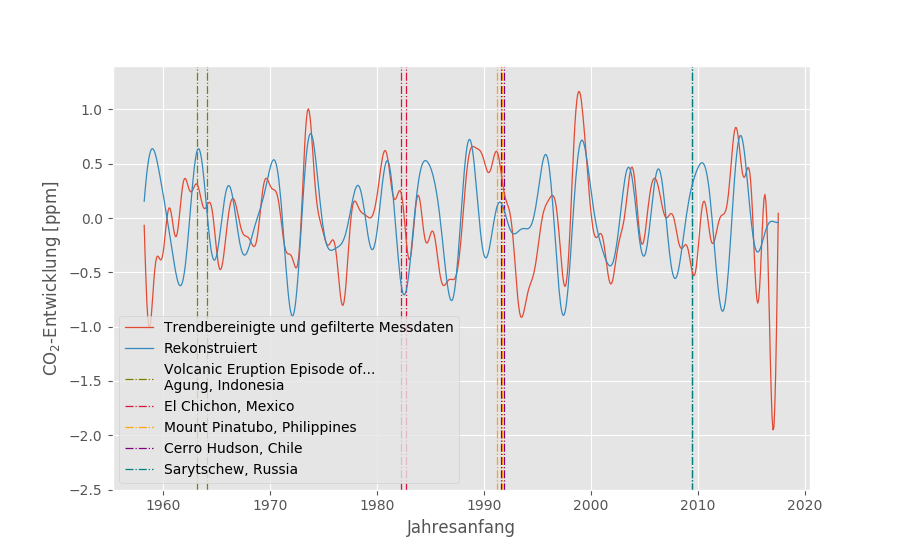

(-2.5, 1.4)

In [23]:
rcParams['figure.figsize'] = 9, 5.5

fig, ax = plt.subplots()
ax.plot(filtered_mmlo.index.values, filtered_mmlo.mmlo_filtered.values, \
       color=myred, label='Trendbereinigte und gefilterte Messdaten')
ax.plot(synth.index.values, synth.raw_noann.values, \
         color=myblue, label='Rekonstruiert')
ax.vlines('1963-02-18', -3, 3, linestyles='dashdot', color='olive', label='Volcanic Eruption Episode of...\nAgung, Indonesia')
ax.vlines('1964-01-27', -3, 3, linestyles='dashdot', color='olive', label='')
ax.vlines('1982-03-28', -3, 3, linestyles='dashdot', color='crimson', label='El Chichon, Mexico')
ax.vlines('1982-09-11', -3, 3, linestyles='dashdot', color='crimson', label='')
ax.vlines('1991-04-02', -3, 3, linestyles='dashdot', color='orange', label='Mount Pinatubo, Philippines')
ax.vlines('1991-09-02', -3, 3, linestyles='dashdot', color='orange', label='')
ax.vlines('1991-08-08', -3, 3, linestyles='dashdot', color='purple', label='Cerro Hudson, Chile')
ax.vlines('1991-10-27', -3, 3, linestyles='dashdot', color='purple', label='')
ax.vlines('2009-06-11', -3, 3, linestyles='dashdot', color='teal', label='Sarytschew, Russia')
ax.vlines('2009-06-21', -3, 3, linestyles='dashdot', color='teal', label='')

ax.set_ylim(-2.5, 1.4)
ax.set_ylabel('CO$_2$-Entwicklung [ppm]')
ax.set_xlabel('Jahresanfang')
ax.legend(loc='lower left')
plt.savefig('plots/synth_mmlo_raw_detrended_noann_volc.pdf')

##### Reconstructed CO2-Development with Forecast (with Annual Variations but without long-term Trend):

<IPython.core.display.Javascript object>


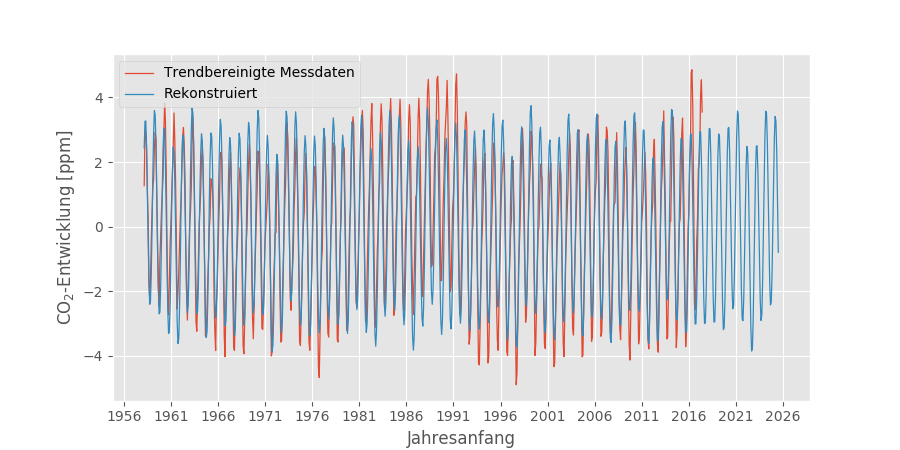

In [24]:
rcParams['figure.figsize'] = 9, 4.5

fig, ax = plt.subplots()
ax.plot(mmlo.index.values, mmlo.mmlo_notrend.values, \
       color=myred, label='Trendbereinigte Messdaten')
ax.plot(synth_future.index.values, synth_future.raw_ann.values, \
         color=myblue, label='Rekonstruiert')

ax.set_ylabel('CO$_2$-Entwicklung [ppm]')
ax.set_xlabel('Jahresanfang')
ax.set_xticks(pd.date_range(start='1956', end='2029', freq='5A-JAN'))
plt.legend()
plt.savefig('plots/synth_mmlo_prog_detrended_ann.pdf')


## Reconstructed Development of CO2-Concentrations with long-term Trend

##### Reconstructed CO2-Development with Forecast (with Annual Variations and long-term Trend):

<IPython.core.display.Javascript object>


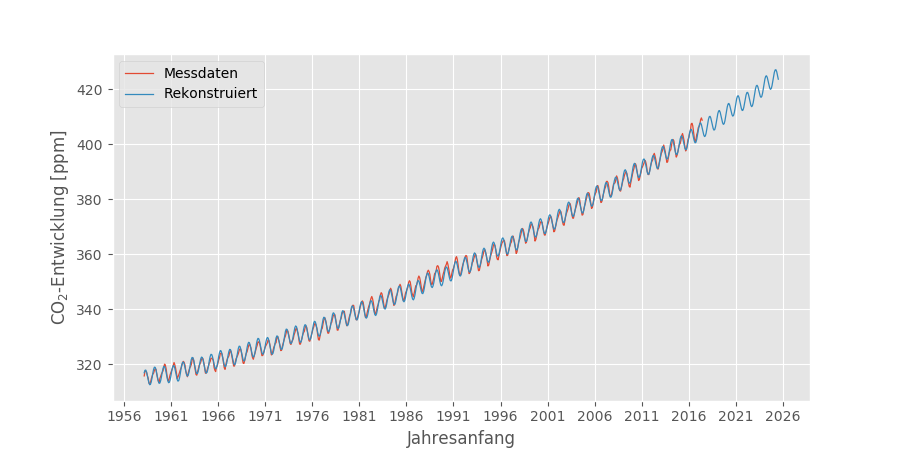

In [25]:
rcParams['figure.figsize'] = 9, 4.5


fig, ax = plt.subplots()
ax.plot(mmlo.index.values, mmlo.mmlo_data.values, \
       color=myred, label='Messdaten')
ax.plot(synth_future.index.values, synth_future.prog_ann.values, \
         color=myblue, label='Rekonstruiert')

ax.set_ylabel('CO$_2$-Entwicklung [ppm]')
ax.set_xlabel('Jahresanfang')
ax.set_xticks(pd.date_range(start='1956', end='2029', freq='5A-JAN'))
plt.legend()
plt.savefig('plots/synth_mmlo_prog.pdf')

##### Reconstructed CO2-Development with Annual Variations and long-term Trend - besides major Volanic Eruption Episodes:

<IPython.core.display.Javascript object>


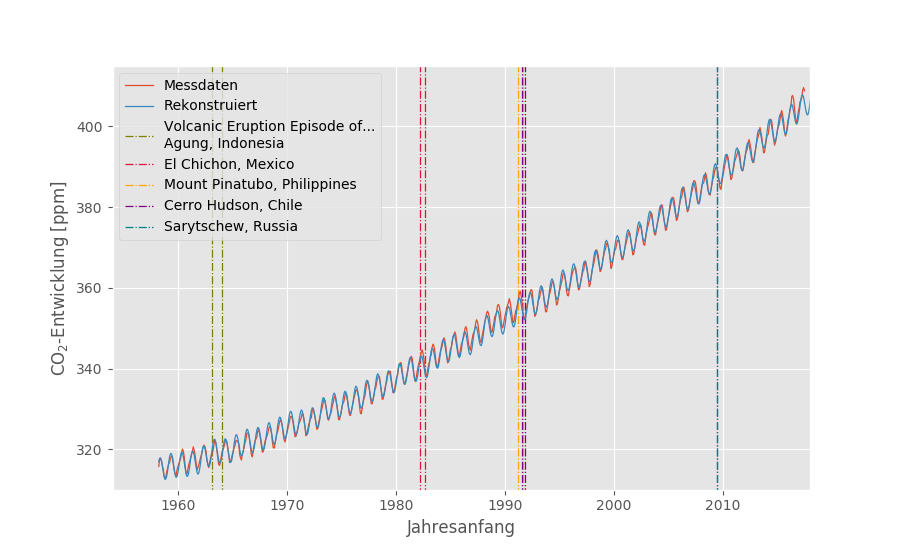

(713319.0, 736695.0)

(310, 415)

In [26]:
rcParams['figure.figsize'] = 9, 5.5

fig, ax = plt.subplots()
ax.plot(mmlo.index.values, mmlo.mmlo_data.values, \
       color=myred, label='Messdaten')
ax.plot(synth_future.index.values, synth_future.prog_ann.values, \
         color=myblue, label='Rekonstruiert')

ax.vlines('1963-02-18', 200, 500, linestyles='dashdot', color='olive', label='Volcanic Eruption Episode of...\nAgung, Indonesia')
ax.vlines('1964-01-27', 200, 500, linestyles='dashdot', color='olive', label='')
ax.vlines('1982-03-28', 200, 500, linestyles='dashdot', color='crimson', label='El Chichon, Mexico')
ax.vlines('1982-09-11', 200, 500, linestyles='dashdot', color='crimson', label='')
ax.vlines('1991-04-02', 200, 500, linestyles='dashdot', color='orange', label='Mount Pinatubo, Philippines')
ax.vlines('1991-09-02', 200, 500, linestyles='dashdot', color='orange', label='')
ax.vlines('1991-08-08', 200, 500, linestyles='dashdot', color='purple', label='Cerro Hudson, Chile')
ax.vlines('1991-10-27', 200, 500, linestyles='dashdot', color='purple', label='')
ax.vlines('2009-06-11', 200, 500, linestyles='dashdot', color='teal', label='Sarytschew, Russia')
ax.vlines('2009-06-21', 200, 500, linestyles='dashdot', color='teal', label='')

ax.set_xlim('1954', '2018')
ax.set_ylim(310, 415)
ax.set_ylabel('CO$_2$-Entwicklung [ppm]')
ax.set_xlabel('Jahresanfang')
plt.legend()
plt.savefig('plots/synth_mmlo_prog_volc.pdf')

##### Reconstructed CO2-Development with Forecast (with Annual Variations and long-term Trend), Recent Detail View:

<IPython.core.display.Javascript object>


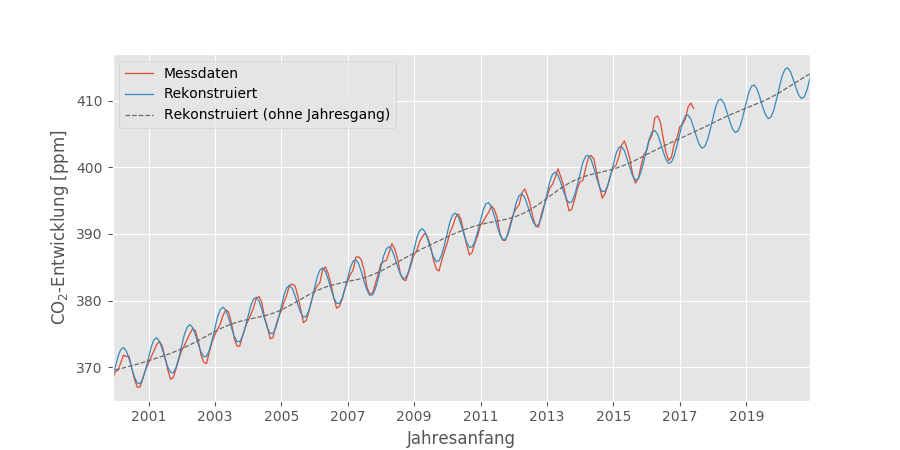

(730120.0, 737791.0)

(365, 417)

In [27]:
rcParams['figure.figsize'] = 9, 4.5


fig, ax = plt.subplots()
ax.plot(mmlo.index.values, mmlo.mmlo_data.values, \
       color=myred, label='Messdaten')
ax.plot(synth_future.index.values, synth_future.prog_ann.values, \
        color=myblue, label='Rekonstruiert')
ax.plot(synth_future.index.values, synth_future.prog_noann.values, \
         '--', color='dimgrey', label='Rekonstruiert (ohne Jahresgang)')

ax.set_ylabel('CO$_2$-Entwicklung [ppm]')
ax.set_xlabel('Jahresanfang')

ax.set_xticks(pd.date_range(start='2001', end='2020', freq='2A-JAN'))
ax.set_xlim('2000', '2021')
ax.set_ylim(365, 417)
plt.legend()
plt.savefig('plots/synth_mmlo_prog_detail.pdf')

##### Reconstructed CO2-Development with Forecast (with long-term Trend, but without Annual Variations for Reconstructed Trend):

<IPython.core.display.Javascript object>


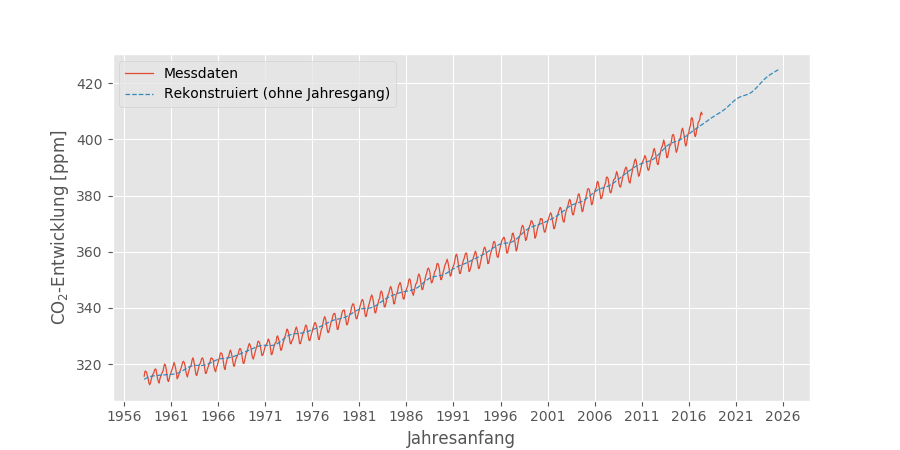

In [28]:
rcParams['figure.figsize'] = 9, 4.5


fig, ax = plt.subplots()
ax.plot(mmlo.index.values, mmlo.mmlo_data.values, \
       color=myred, label='Messdaten')
ax.plot(synth_future.index.values, synth_future.prog_noann.values, \
         '--', color=myblue, label='Rekonstruiert (ohne Jahresgang)')

ax.set_ylabel('CO$_2$-Entwicklung [ppm]')
ax.set_xlabel('Jahresanfang')
ax.set_xticks(pd.date_range(start='1956', end='2029', freq='5A-JAN'))
plt.legend()
plt.savefig('plots/synth_mmlo_prog_noann.pdf')

##### Reconstructed CO2-Development with long-term Trend, but without Annual Variations for Reconstructed Trend - besides major Volanic Eruption Episodes, Detail View for Years 1980 - 2013:

<IPython.core.display.Javascript object>


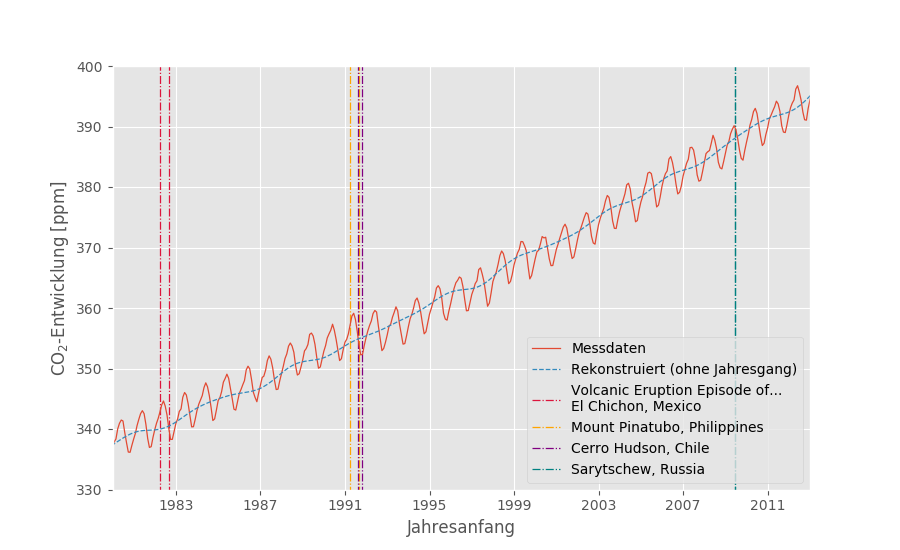

(722815.0, 734869.0)

(330, 400)

In [29]:
rcParams['figure.figsize'] = 9, 5.5


fig, ax = plt.subplots()
ax.plot(mmlo.index.values, mmlo.mmlo_data.values, \
       color=myred, label='Messdaten')
ax.plot(synth_future.index.values, synth_future.prog_noann.values, \
         '--', color=myblue, label='Rekonstruiert (ohne Jahresgang)')

# ax.vlines('1963-02-18', 200, 500, linestyles='dashdot', color='olive', label='Volcanic Eruption Episode of...\nAgung, Indonesia')
# ax.vlines('1964-01-27', 200, 500, linestyles='dashdot', color='olive', label='')
ax.vlines('1982-03-28', 200, 500, linestyles='dashdot', color='crimson', label='Volcanic Eruption Episode of...\nEl Chichon, Mexico')
ax.vlines('1982-09-11', 200, 500, linestyles='dashdot', color='crimson', label='')
ax.vlines('1991-04-02', 200, 500, linestyles='dashdot', color='orange', label='Mount Pinatubo, Philippines')
ax.vlines('1991-09-02', 200, 500, linestyles='dashdot', color='orange', label='')
ax.vlines('1991-08-08', 200, 500, linestyles='dashdot', color='purple', label='Cerro Hudson, Chile')
ax.vlines('1991-10-27', 200, 500, linestyles='dashdot', color='purple', label='')
ax.vlines('2009-06-11', 200, 500, linestyles='dashdot', color='teal', label='Sarytschew, Russia')
ax.vlines('2009-06-21', 200, 500, linestyles='dashdot', color='teal', label='')

ax.set_xlim('1980', '2013')
ax.set_ylim(330, 400)

ax.set_ylabel('CO$_2$-Entwicklung [ppm]')
ax.set_xlabel('Jahresanfang')
plt.legend(loc='lower right')
plt.savefig('plots/synth_mmlo_prog_noann_1980_2013_volc.pdf')